In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import data visualization
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Bengali.AI EDA

[Bengali alphabet](https://en.wikipedia.org/wiki/Bengali_alphabet)

## Dataset Statistics

Output the list of files:

In [2]:
! ls ../input/bengaliai-cv19/

class_map.csv		   test_image_data_3.parquet
sample_submission.csv	   train.csv
test.csv		   train_image_data_0.parquet
test_image_data_0.parquet  train_image_data_1.parquet
test_image_data_1.parquet  train_image_data_2.parquet
test_image_data_2.parquet  train_image_data_3.parquet


In [3]:
# setup the input data folder
DATA_PATH = '../input/bengaliai-cv19/'

Load the labels and explore target classes and distribution of images between them:

In [4]:
# load the dataframes with labels
train_labels = pd.read_csv(DATA_PATH + 'train.csv')
test_labels = pd.read_csv(DATA_PATH + 'test.csv')
class_map = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [5]:
print('There are {} train images.'.format(len(train_labels)))
print('There are {} test images.'.format(len(test_labels.groupby(by=['image_id']).count())))
print('There are {} classes for all 3 targets.'.format(len(class_map)))

There are 200840 train images.
There are 12 test images.
There are 186 classes for all 3 targets.


In [6]:
# count the number of classes for each target
n_classes = class_map.groupby(by=['component_type']).count()

In [7]:
# source: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

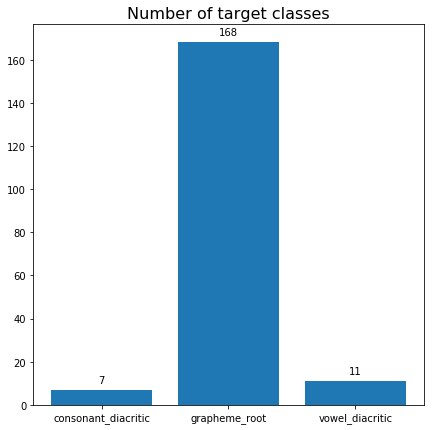

In [8]:
# plot bar chart with the number of classes to predict
fig, ax = plt.subplots(1,1,figsize=(7,7))
plt.bar(range(0,len(n_classes.label.values)), n_classes.label.values)
plt.xticks(range(0,len(n_classes.label.values)), n_classes.index.values)
plt.title('Number of target classes', fontsize=16)
add_value_labels(ax)
plt.show()

Let's look at the number of images for each class:

In [9]:
# count the number of images for each grapheme_root
grapheme_root_img = train_labels.groupby(by=['grapheme_root']).count().reset_index()[['grapheme_root', 'image_id']]\
.sort_values(by=['image_id'], ascending=False)

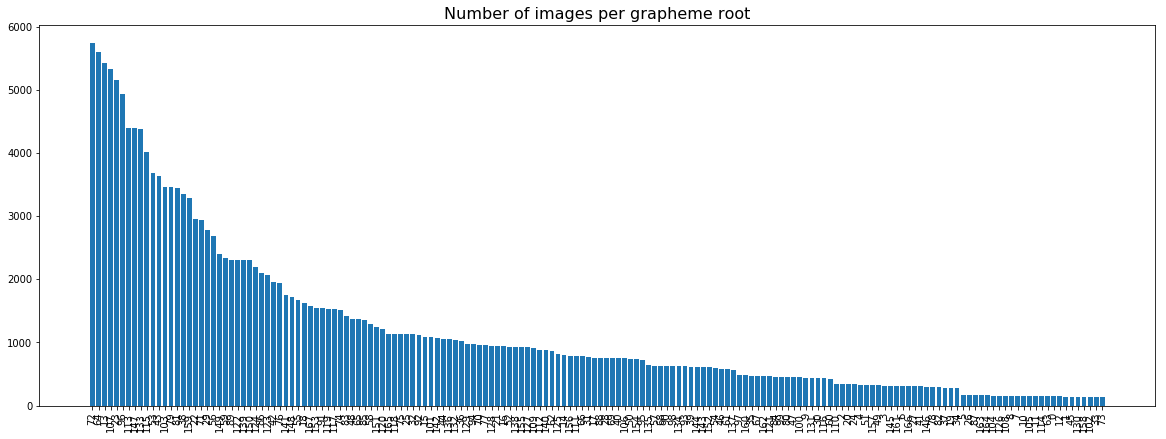

In [10]:
# plot bar chart with the number of images per each grapheme root
n_classes = len(grapheme_root_img)
fig, ax = plt.subplots(1,1,figsize=(20,7))
plt.bar(range(0, n_classes), grapheme_root_img.image_id.values)
plt.xticks(range(0, n_classes), grapheme_root_img.grapheme_root.values, rotation=90)
plt.title('Number of images per grapheme root', fontsize=16)
plt.show()

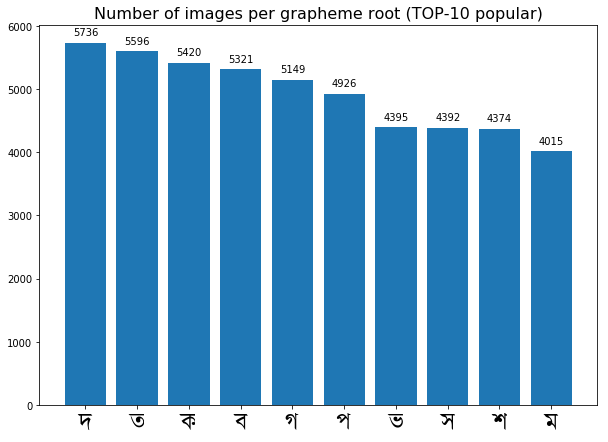

In [11]:
# plot bar chart with the top popular grapheme root class
n_classes = 10
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), grapheme_root_img.image_id.values[:n_classes])
labels = [class_map[class_map.label == val].component.values[0] for val in grapheme_root_img.grapheme_root.values[:n_classes]]
prop = FontProperties()
prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per grapheme root (TOP-10 popular)', fontsize=16)
add_value_labels(ax)
plt.show()

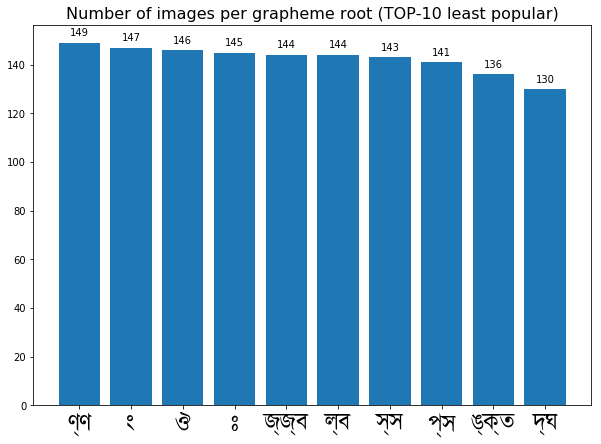

In [12]:
# plot bar chart with the top popular grapheme root class
n_classes = 10
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), grapheme_root_img.image_id.values[-n_classes:])
labels = [class_map[class_map.label == val].component.values[0] for val in grapheme_root_img.grapheme_root.values[-n_classes:]]
prop = FontProperties()
prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per grapheme root (TOP-10 least popular)', fontsize=16)
add_value_labels(ax)
plt.show()

In [13]:
# count the number of images for each vowel_diacritic
vowel_diacritic_img = train_labels.groupby(by=['vowel_diacritic']).count().reset_index()[['vowel_diacritic', 'image_id']]\
.sort_values(by=['image_id'], ascending=False)

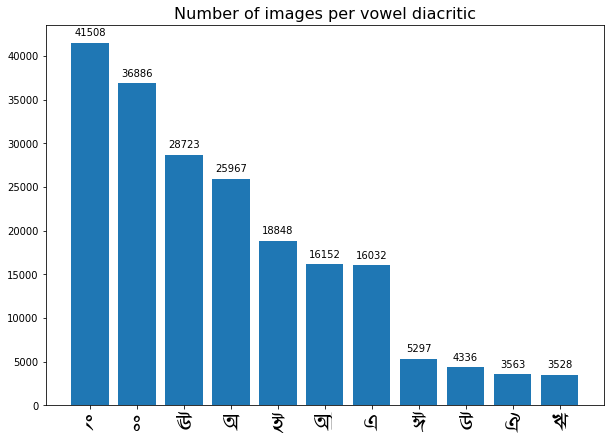

In [14]:
# plot bar chart with the number of images per each vowel_diacritic
n_classes = len(vowel_diacritic_img)
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), vowel_diacritic_img.image_id.values)
labels = [class_map[class_map.label == val].component.values[0] for val in vowel_diacritic_img.vowel_diacritic.values]
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per vowel diacritic', fontsize=16)
add_value_labels(ax)
plt.show()

In [15]:
# count the number of images for each consonant_diacritic
consonant_diacritic_img = train_labels.groupby(by=['consonant_diacritic']).count().reset_index()[['consonant_diacritic', 'image_id']]\
.sort_values(by=['image_id'], ascending=False)

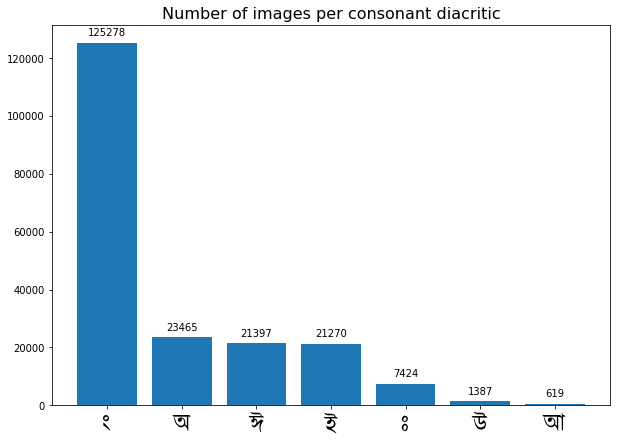

In [16]:
# plot bar chart with the number of images per each consonant_diacritic
n_classes = len(consonant_diacritic_img)
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), consonant_diacritic_img.image_id.values)
labels = [class_map[class_map.label == val].component.values[0] for val in consonant_diacritic_img.consonant_diacritic.values]
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per consonant diacritic', fontsize=16)
add_value_labels(ax)
plt.show()

__Conclusions:__
* We have a __lot of target classes__. There are 168 classes for one of the target variables.
* The __distribution of images between the classes varies greately__, especially for `grapheme root` and `consonant diacritic`

## Visualize Sample Images

Load the first data file ([parquet format wiki page](https://en.wikipedia.org/wiki/Apache_Parquet)) and visualize sample image:

In [17]:
# load the 1st data file
train_df_1 = pd.read_parquet(DATA_PATH + 'train_image_data_0.parquet')
train_df_1.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [18]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236

# function to visualize the images
def visualize_image(df, image_id):
    '''
    Helper function to visualize the image from dataframe by image_id
    '''
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH)
    plt.imshow(img.astype(float), cmap='gray')
    plt.show()

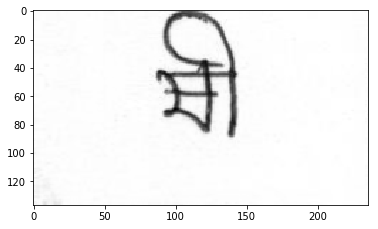

In [19]:
visualize_image(train_df_1, 'Train_7')

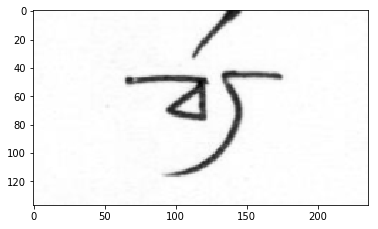

In [20]:
visualize_image(train_df_1, 'Train_11')

Load all images:

In [21]:
def load_images():
    '''
    Helper function to load all train and test images
    '''
    train_list = []
    for i in range(0,4):
        train_list.append(pd.read_parquet(DATA_PATH + 'train_image_data_{}.parquet'.format(i)))
    train = pd.concat(train_list, ignore_index=True)
    
    test_list = []
    for i in range(0,4):
        test_list.append(pd.read_parquet(DATA_PATH + 'test_image_data_{}.parquet'.format(i)))
    test = pd.concat(test_list, ignore_index=True)
    
    return train, test

# function to visualize the images
def visualize_image_label(df, image_id, train_labels):
    '''
    Helper function to visualize the image from dataframe by image_id
    '''
    grapheme = train_labels[train_labels.image_id == image_id].grapheme.values[0]
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH)
    plt.imshow(img.astype(float), cmap='gray')
    
    prop = FontProperties()
    prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
    
    plt.title(grapheme, fontproperties=prop, fontsize=20)
    plt.show()

In [22]:
# load the images
train, test = load_images()

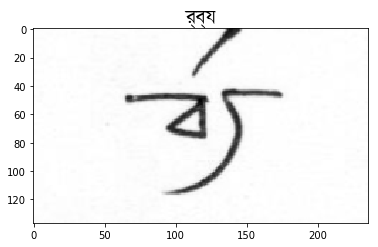

In [23]:
# visualize an image with label
visualize_image_label(train_df_1, 'Train_11', train_labels)

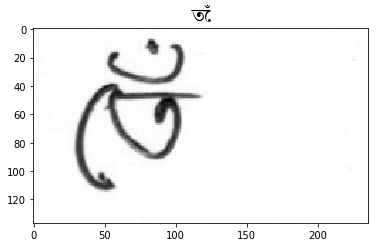

In [24]:
# visualize an image with label
visualize_image_label(train_df_1, 'Train_9', train_labels)

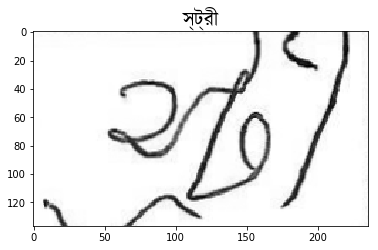

In [25]:
# visualize an image with label
visualize_image_label(train_df_1, 'Train_56', train_labels)

## References
1. [Bengali fonts](https://www.omicronlab.com/bangla-fonts.html) to use for matplotlib diagrams